## Importing libraries 

In [1]:
import os
import email
from email.policy import default
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import random 
import numpy as np 
import re
import mailbox
from bs4 import BeautifulSoup
import email
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


2024-06-10 09:06:58.562972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 09:06:58.563084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 09:06:58.696276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# checking for gpu 

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fa00ac7f-e9a9-e638-8901-947ee5ec6bca)
GPU 1: Tesla T4 (UUID: GPU-5554b0bf-60ee-fafa-2133-75b4b44a93eb)


In [3]:
# installing packages
!pip freeze > kaggle_image_requirements.txt
!pip install tensorflow-text


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


## Getting phishing and ham data

In [4]:

def extract_message_bodies(text):
    # Split the text by the pattern that typically indicates the start of a new email
    messages = re.split(r'From r\s+', text)
    
    # Define a pattern to match the email headers which are typically followed by a blank line
    header_pattern = re.compile(r'(.*?)\n\n', re.DOTALL)
    
    phishing_messages_1 = []
    
    for message in messages:
        if not message.strip():
            continue
        
        # Find the header and remove it to get the body
        header_match = header_pattern.match(message)
        if header_match:
            body = message[header_match.end():].strip()
        else:
            # If no header match is found, treat the whole message as the body
            body = message.strip()
        
        phishing_messages_1.append(body)
    
    return phishing_messages_1


with open('/kaggle/input/fraudulent-email-corpus/fradulent_emails.txt',encoding='latin1') as f : 
    text=f.read()
# Extract message bodies
phishing_messages_1 = extract_message_bodies(text)

# Print the message bodies to verify
# for idx, body in enumerate(message_bodies):
#     print(f"Message {idx + 1} Body:\n{body}\n{'-'*50}\n")


In [5]:
len(phishing_messages_1)

3976

In [6]:
phishing_messages_1[500]

"From: J. Rodney Chesson \nChesson Family Corporation,\nLiberia.\nEmail: jrchesson@rediffmail.com\n\nKindest attention,\n\nI am very sorry for the informal manner in which this mail is reaching you. This is necessitated by my urgent need to reach a dependable and trustworthy foreign partner. This request may seem strange and unsolicited but I crave your indulgence and pray that you take my request very serious.\n\nI am Mr. J. Rodney Chesson, the first son of Late J. J. F. Chesson (Liberian Minister of Justice 1979 to 1980). On April 22, 1980, my father along with 12 other Liberian Government officials was assassinated as a result of a military coup that toppled the government of President William\nR. Tolbert, Jr. May his soul rest in Eternal Peace. Since then, my family has always been seen as a symbol of peace in Liberia. \n\nI received information from a reliable source that described your country as being economically conducive for investment and her people as transparent and trustw

In [7]:
## getting ham data from email-spam-dataset-extended  dataset 

# Directory containing the email files
directory_ham = '/kaggle/input/email-spam-dataset-extended/ham_zipped/main_ham'

# List to store the message bodies
ham_messages = []

# Function to extract the body from an email message
def extract_body(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_ham):
    file_path = os.path.join(directory_ham, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body(msg)
    
    # Append the body to the list
    if body:
        ham_messages.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total ham messages extracted: {len(ham_messages)} email-spam-dataset-extended/ham_zipped/main_ham')


Total ham messages extracted: 6947 email-spam-dataset-extended/ham_zipped/main_ham


In [8]:
ham_messages[5]

'\n[can\'t think of how I\'d be running\nafoul of the spam filters with this\npost, so here\'s the second try...]\n\nKissinger\'s book _Does America Need\na Foreign Policy?_ provides a few\nhandy abstractions:\n\n> The ultimate dilemma of the statesman is to strike a balance between\n> values ["idealism"] and interests ["realism"] and, occasionally,\n> between peace and justice.\n\nAlso, he views historical American\napproaches to foreign policy as a\nbundle of three fibers:\n\nHamiltonian - We should only get\n  involved in foreign adventures\n  to preserve balances of power.\n\nWilsonian - We should only get\n  involved in foreign adventures\n  to further democracy, etc.\n\nJacksonian - We should never get\n  involved in foreign adventures.\n  Unless we\'re attacked.  Then we\n  go Rambo.\n\nHe has tactfully left out the hard\nrealists*; as for the rest I gather\nwilsonians play the idealists, and\nhamiltonians act where values and\ninterests intersect, and jacksonians \nact only whe

In [9]:

## getting phishing data from email-spam-dataset-extended 

# Directory containing the email files
directory_spam = '/kaggle/input/email-spam-dataset-extended/spam_zipped/main_spam'

# List to store the message bodies
phishing_messages_2 = []

# Function to extract the body from an email message
def extract_body_from_spam(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_spam):
    file_path = os.path.join(directory_spam, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body_from_spam(msg)
    
    # Append the body to the list
    if body:
        phishing_messages_2.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total phishing messages extracted {len(phishing_messages_2)} from email-spam-dataset-extended/spam_zipped/main_spam')


Total phishing messages extracted 2293 from email-spam-dataset-extended/spam_zipped/main_spam


In [10]:
phishing_messages_2[:5]

['<html>\n\n<head>\n<meta http-equiv="Content-Language" content="en-us">\n<meta name="GENERATOR" content="Microsoft FrontPage 5.0">\n<meta name="ProgId" content="FrontPage.Editor.Document">\n<meta http-equiv="Content-Type" content="text/html; charset=windows-1252">\n<title>Norton AD</title>\n</head>\n\n<body>\n\n<table border="3" cellspacing="3" width="469" cellpadding="3" bgcolor="#000080"  bordercolor="#FFFFFF" style="border-collapse: collapse" bordercolordark="#FFFFFF">\n  <tr>\n    <td width="447">&nbsp;\n      <table border="1" width="100%" bgcolor="#FFFFFF" bordercolor="#000080">\n        <tr>\n          <td width="100%" align="center"><font face="Impact" size="4" color="#CC0000">ATTENTION:\n            This is a MUST for <u>ALL</u> Computer Users!!!</font></td>\n        </tr>\n      </table>\n      <p align="center"><font size="3" face="Verdana"><b>&nbsp;<font color="#FFFFFF">*NEW\n      - Special Package Deal!*</font></b></font></p>\n      <table border="8" width="100%" height=

In [11]:
## getting meassages from html like messages 

def extract_message_body(message):
    soup = BeautifulSoup(message, 'html.parser')
    body = soup.get_text(separator='\n')
    return body.strip()

# List of messages
phishing_messages_3=[]
for ph_message in phishing_messages_2 : 
    phishing_messages_3.append(extract_message_body(ph_message))

In [12]:
phishing_messages_3[0]

"Norton AD\n\n\n\n\n\n\n\n\n\n\n\xa0\n      \n\n\n\n\nATTENTION:\n            This is a MUST for \nALL\n Computer Users!!!\n\n\n\n\n\n\n\xa0\n*NEW\n      - Special Package Deal!*\n\n\n\n\n\n\nNorton\n            SystemWorks 2002 Software Suite\n\n            -\nProfessional Edition\n-\n\n\n\n\n\n\n\n\n\n\nIncludes\n            Six - \nYes 6!\n - Feature-Packed Utilities\nALL\n            for \n1\n\n            Special \nLOW\n\n            Price!\n\n\n\n\n\n\n\n\n\n\nThis Software Will:\n- Protect your\n            computer from unwanted and \n hazardous\n viruses\n- Help secure your\n            private & valuable information\n- Allow you to transfer files\n            and send e-mails \n safely\n- Backup your ALL your data quick and\n            easily\n- Improve your PC's performance w/\nsuperior\n\n            integral diagnostics!\n\n\n\n\n\xa0\n      \n\n\n\n\n\n\n6\n\n\nFeature-Packed Utilities\n\n\n1\n\n\n Great\n            Price\n \n\n\n\n            A\n \n$300+\n \n Combined 

In [13]:
## removing \n  from phishing_messages_3
phishing_messages_4=[]
for ph_message in phishing_messages_3 : 
    cleaned=ph_message.replace('\n','')
    phishing_messages_4.append(cleaned)

In [14]:
phishing_messages_4[0]

"Norton AD\xa0      ATTENTION:            This is a MUST for ALL Computer Users!!!\xa0*NEW      - Special Package Deal!*Norton            SystemWorks 2002 Software Suite            -Professional Edition-Includes            Six - Yes 6! - Feature-Packed UtilitiesALL            for 1            Special LOW            Price!This Software Will:- Protect your            computer from unwanted and  hazardous viruses- Help secure your            private & valuable information- Allow you to transfer files            and send e-mails  safely- Backup your ALL your data quick and            easily- Improve your PC's performance w/superior            integral diagnostics!\xa0      6Feature-Packed Utilities1 Great            Price             A $300+  Combined Retail Value            YOURS for Only $29.99!<Includes            FREE Shipping!> Don't fall prey to destructive viruses    or hackers!Protect\xa0 your computer and your valuable  information    and->            CLICK HERE to Order Yours NOW

In [15]:
## removing \xa0  from phishing_messages_3

phishing_messages_5=[]
for ph_message in phishing_messages_4 : 
    cleaned=ph_message.replace('\xa0','')
    phishing_messages_5.append(cleaned)
    

In [16]:
phishing_messages_5[0]

"Norton AD      ATTENTION:            This is a MUST for ALL Computer Users!!!*NEW      - Special Package Deal!*Norton            SystemWorks 2002 Software Suite            -Professional Edition-Includes            Six - Yes 6! - Feature-Packed UtilitiesALL            for 1            Special LOW            Price!This Software Will:- Protect your            computer from unwanted and  hazardous viruses- Help secure your            private & valuable information- Allow you to transfer files            and send e-mails  safely- Backup your ALL your data quick and            easily- Improve your PC's performance w/superior            integral diagnostics!      6Feature-Packed Utilities1 Great            Price             A $300+  Combined Retail Value            YOURS for Only $29.99!<Includes            FREE Shipping!> Don't fall prey to destructive viruses    or hackers!Protect your computer and your valuable  information    and->            CLICK HERE to Order Yours NOW! <-Click      h

In [17]:
## getting data from phishingemaildetection dataset 

# Path to the mbox file
legal_emails_file = '/kaggle/input/phishingemaildetection/emails-enron-legal-mails.mbox'

# List to store the message bodies
legal_emils = []

# Function to extract the body from an email message
def extract_body_from_legal(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode('utf-8', errors='replace')
    else:
        return msg.get_payload(decode=True).decode('utf-8', errors='replace')

# Open the mbox file
mbox = mailbox.mbox(legal_emails_file)

# Iterate through each message in the mbox file
for msg in mbox:
    # Extract the message body
    body = extract_body_from_legal(msg)
    
    # Append the body to the list
    if body:
        legal_emils.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total messages extracted from  emails-enron-legal-mails.mbox : {len(legal_emils)}')

# Optional: Print the first message to check


Total messages extracted from  emails-enron-legal-mails.mbox : 4279


In [18]:
# let's have a look on legal messages extracted from emails-enron-legal-mails.mbox
for message in random.sample(legal_emils,2): 
    print(message,'\n\n\n','#'*100)


	jeff.richter@enron.com, robert.frank@enron.com, tim.belden@enron.com, 
	richard.shapiro@enron.com, paul.kaufman@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: alan.comnes@enron.com, james.steffes@enron.com, jeff.dasovich@enron.com, 
	jeff.richter@enron.com, robert.frank@enron.com, tim.belden@enron.com, 
	richard.shapiro@enron.com, paul.kaufman@enron.com
X-From: Susan J Mara
X-To: Ray Alvarez
X-cc: Alan Comnes, James D Steffes, Jeff Dasovich, jeff.richter@enron.com, Robert Frank, Tim Belden, Richard Shapiro, Paul Kaufman
X-bcc: 
X-Folder: \Richard_Shapiro_Nov2001\Notes Folders\California
X-Origin: SHAPIRO-R
X-FileName: rshapiro.nsf

CONFIDENTIAL -- FERC SETTLEMENT DISCUSSIONS

I have proposed quite a few changes and additions to the list.  I also ask 
some questions re some of the items listed. I added a section on Retail 
Reforms -- we cannot settle with the state unless we settle everything -- 
otherwise we know the outcome

In [19]:
# legal_emils[600:605]

In [20]:
## cleaning legal_eamils list to get message bodies 

def clean_legal_email_body(email):
    # Remove forwarded or replied metadata
    email = re.sub(r'(--+ Forwarded by .* --+|--+ Original Message --+|--+ Reply Separator --+)', '', email, flags=re.IGNORECASE)
    # Remove email headers (To, From, Cc, etc.)
    email = re.sub(r'(^|\n)(From|To|Cc|Subject|Bcc):.*(\n|$)', '', email, flags=re.IGNORECASE)
    # Remove metadata that appears after the body
    email = re.sub(r'(\n\n.*(On .* wrote:|Sent from my .*|From: .*|Subject: .*|\[Quoted text hidden\]))', '', email, flags=re.IGNORECASE)
    # Remove leading and trailing whitespace
    email = email.strip()
    return email

def extract_and_clean_legal_emails(email_list):
    cleaned_bodies = []
    for email in email_list:
        cleaned_body = clean_legal_email_body(email)
        cleaned_bodies.append(cleaned_body)
    return cleaned_bodies

# Example usage with the email samples
# cleaned_emails = extract_and_clean_emails(emails)
# print(cleaned_emails)
legal_emils_cleaned=extract_and_clean_legal_emails(legal_emils)

 > ##### legal_emils_cleaned is the final version of cleaned emails gotten from phishingemaildetection/emails-enron-legal-mails.mbox
 


In [21]:
# lets have a look on sample of cleaned legal emails extracted from emails-enron-legal-mails.mbox
for m in random.sample(legal_emils_cleaned,2): 
    print(m,'\n\n','#'*100)

Tana:

The following are NOT authorized for US power:

En Vantage, Inc. - restricted by credit
Global Crossing Ltd. - restricted by credit
Thermo Ecotek Corporation - not a current CP/not FERC authorized

***********************8
I need to follow up on MRT Energy Marketing Company on Monday -- I'm not 
positive that this entity is actually a division, as opposed to a subsidiary.

Leslie 

 ####################################################################################################
czolezzi@hotmail.com, roberthootgibson@compuserve.com, 
	rhea.seddon@mcmail.vanderbilt.edu, susan.m.scott@enron.com, 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Julie Gibson <julieg@qualcomm.com>
X-To: Whitworth 2nd Lt Brendan R <WhitworthBR@i-mef.usmc.mil>, Cynthia Stumbo <cstumbo@marstonandmarston.com>, Cara Zolezzi <czolezzi@hotmail.com>, "RobertHootGibson@compuserve.com" <RobertHootGibson@compuserve.com>, "Rhea.Seddon@mcmail.vanderbilt.edu"

### Getting phishing emails from  emails-phishing-nazario.mbox

In [22]:


# Path to the mbox file
phishing_nazario_file_path = "/kaggle/input/phishingemaildetection/emails-phishing-nazario.mbox"

# Function to extract messages from mbox file
def extract_messages_from_mbox(mbox_file_path):
    messages = []
    mbox = mailbox.mbox(mbox_file_path)
    for message in mbox:
        messages.append(message)
    return messages

# Extract messages from mbox file
phishing_nazario_messages = extract_messages_from_mbox(phishing_nazario_file_path)

# Print the number of extracted messages
print(f"Number of messages: {len(phishing_nazario_messages)}")




Number of messages: 2279


In [23]:
## removing messages that causes Unicodeerror 
import traceback
def clean_messages(messages):
    cleaned_messages = []
    for message in messages:
        try:
            # Attempt to decode and encode message to handle Unicode characters
            message_str = message.as_string()
            message_str.encode('utf-8')
            cleaned_messages.append(message)
        except UnicodeEncodeError:
            # If UnicodeEncodeError occurs, skip the message
#             traceback.print_exc()  # Print traceback to debug the error
            continue
    return cleaned_messages

# Clean the phishing_nazario_messages list
cleaned_phishing_nazario_messages = clean_messages(phishing_nazario_messages)
print(f'removed {len(phishing_nazario_messages)-len(cleaned_phishing_nazario_messages)} messages that causes Unicodeerror')


removed 141 messages that causes Unicodeerror


In [24]:
len(cleaned_phishing_nazario_messages)

2138

In [25]:
# let's have a look on sample of cleaned_phishing_nazario_messages
for m in random.sample(cleaned_phishing_nazario_messages,1):
    print(m,'\n\n')

Return-Path: <paypal.com@bill1.monkey.org>
X-Original-To: user@login.example.com
Delivered-To: user@login.example.com
Received: from mail.example.org (mail.example.org [192.168.4.9])
	by example.com (Postfix) with ESMTP id 2E01846900
	for <user@login.example.com>; Sun, 18 Feb 2007 04:44:44 -0500 (EST)
Received: from mail.example.org (mail.example.org [192.168.6.4])
	by mail.example.org (Postfix) with ESMTP id 111C9131FA92
	for <user@example.com>; Sun, 18 Feb 2007 04:45:00 -0500 (EST)
Received: from bill1 (24-183-58-170.dhcp.mdsn.wi.charter.com [24.183.58.170])
	by mail.example.org (Postfix) with ESMTP id DC0146FA1A8
	for <user@example.com>; Sun, 18 Feb 2007 04:44:59 -0500 (EST)
Received: from User ([202.156.3.181]) by bill1 with Microsoft SMTPSVC(5.0.2195.6713);
	 Sun, 18 Feb 2007 03:50:34 -0600
Reply-To: <aaa@aaa.com>
From: "service"<paypal.com>
Subject: Important Notification
Date: Sun, 18 Feb 2007 17:44:33 +0800
MIME-Version: 1.0
Content-Type: text/html;
	charset="Windows-1251"
Cont

> ##### cleaned_phishing_nazario_messages is like html so we have to get text from it 

In [26]:

# getting text from html for cleaned_phishing_nazario_messages
def extract_phishing_text_from_html(html_content):
    # Convert bytes-like object to string if necessary
    if isinstance(html_content, bytes):
        html_content = html_content.decode('utf-8')
    
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text(separator='\n')
    # Remove the long, seemingly random text at the end
    if '*******' in text:
        text = text.split('*******')[0]
    return text

def extract_text_from_payload(payload):
    if isinstance(payload, str):
        return payload
    elif isinstance(payload, bytes):
        return payload.decode('utf-8')
    elif isinstance(payload, list):
        text = ''
        for part in payload:
            text += extract_text_from_payload(part)
        return text
    elif isinstance(payload, email.message.Message):
        return extract_text_from_payload(payload.get_payload())
    else:
        return ''

# Extract text from HTML content
cleaned_phishing_nazario_messages_text = []
for message in cleaned_phishing_nazario_messages:
    if isinstance(message, email.message.Message):
        html_content = extract_text_from_payload(message)
        if html_content:
            extracted_text = extract_phishing_text_from_html(html_content)
            cleaned_phishing_nazario_messages_text.append(extracted_text)

print(len(cleaned_phishing_nazario_messages_text))


2116


In [27]:
cleaned_phishing_nazario_messages_text[:5]

['in 1841 stars battle    Tour de France in 1872 in 1923 \n\nR0lGODlhZQJsAfPrAAkFAKbK8ICAgABgwACAwCCAwECAwECgwGCgwICgwIDAwP/78AAA/////wAAAAAAACH5BAQAAAAALAAAAABVAmMBAAT/sMlJq7046827/2AojmRpnmiqrmzrvnAsz3Rt33iu73zv/8CgcEgs\nGo/IpHLJbDqf0Kh0Sq1ar9isdsvter+dhXhMLpvFgYACQQC73/C4/BpAFAiDvH7P7/fngIGCg4QxAQV+\niYp9BYWOj5ApdXcEBAUGCQtFC2mdaRaeoaKhUwmLp6cIkausrRcBBouqQwF9BhZ4qHy3Uaa6v3wBrsPE\njrWovDd2BcyXwg3He8kTucAD0zkJBtvczxrR1r/YxeTlXwvVqTiIwRLgeePp4j2x7Rro4dbe5vz9WAj6\nbsgb8OzdNVz5xt2ot2ffBV/5dM3yR7EiFHzAFMIYWNAWwnAa/2sw1OPQAruIp0JaXMkyiMEBCNKc3KOp\nBkd3HisMREavT0kKL1HuqtmyqNEfEPU0wunTxk1oOSkg4LbNDwGqmHrawxBU6AACP4+KHTsDIJ+JDWbm\nSVAhTQIECBQEIGriqUFeC97GBOoHrQVObE+ogZtg7oWRecJKMOtVz1XDZCNLjoEYJoXKExPsvPZsgYFm\nzAzUPAR6GzM/oRnruaX6a8c+qpY1YxsADwHZzQqCZha4wQI2fgwUhDvQANyfnEYpXy5msvPnLVp/JSqd\nrWdUwhb4qSldV+WqfoS9VKVWuOPKr6UxlQVVHSjjcOPLn09ffmG60PPr95BUac0zElSWiP8w2y0WkYCK\nNDJeA/J8dl5T7anXFR+FoeKXBP01xtl+HHb4SiJgZTAhHwVo1wd3B4aTRl8MLnIVhHelBUx3Z11gooZn\n4efhjs9h1JeODQi42UsoJqTijXuoslkeL9pj0AE

In [28]:
## removing long bad text that is longer than 25 words 
def remove_long_words(messages):
    cleaned_messages = []
    for message in messages:
        words = message.split()
        cleaned_words = [word for word in words if len(word) <= 25]
        cleaned_message = ' '.join(cleaned_words)
        cleaned_messages.append(cleaned_message)
    return cleaned_messages

# Example usage:

cleaned_phishing_nazario_messages_text_1 = remove_long_words(cleaned_phishing_nazario_messages_text)
# for cleaned_message in cleaned_messages:
#     print(cleaned_message)


In [29]:
## removing \n and 0x from meassages 
cleaned_phishing_nazario_messages_text_2=[]
for m in cleaned_phishing_nazario_messages_text_1 :
    m=m.replace('\n','')
    m=re.sub('[0x\d]+','',m)
    m=m.replace(',','')
    cleaned_phishing_nazario_messages_text_2.append(m)
    
    

In [30]:
cleaned_phishing_nazario_messages_text_2[:5]

['in  stars battle Tour de France in  in ',
 'Dear eBay User  After fraud complaints from the eBay members the eBay Inc. had developed a security program against the fraudulend attempts of accounts thefts. For that we have to securise all the members informations by updating and checking the registrated informations. Please update your information by completing the form from the forwarded link so we can check your account validity and your identity and login to eBay in order to update your informations. This process will take  days period when you will not be able to acces your eBay account. After this period you will receive instructions to enter and securise your eBay account.Please click the link below and sign in into your account: -- As outlined in our User Agreement eBay will periodically send you information about site changes and enhancements. Visit our Privacy Policy and User Agreement if you have any questions. RegardsSafeharbor Department eBay Inc.',
 "Dear valued customer O

## Getting all data into a dataframe 

In [31]:
## making a dataframe from ham messages 
all_ham_messages=ham_messages+legal_emils_cleaned#+ham_messages_2100
ham_df=pd.DataFrame({'phishing':[0]*len(all_ham_messages),'text':all_ham_messages})
ham_df

,phishing,text
0,0,\nme:\n> >Spam is *the* tool for dissident new...
1,0,Chuck Murcko wrote:\n> > The usual crud. Why ...
2,0,<html><head><!--\n\n CLICK HERE to read t...
3,0,"On Wednesday 31 July 2002 12:02, Satelle, Stev..."
4,0,URL: http://scriptingnews.userland.com/backiss...
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\r\n\r\nhttp://cips.ferc.fed.us/...
11223,0,This is really good.\r\n\r\n------------------...
11224,0,That actually made me cry.\r\n\r\nSusan


In [32]:
## making a dataframe from phishing data
all_phishing_data=phishing_messages_1+phishing_messages_5+cleaned_phishing_nazario_messages_text_2
phishing_df=pd.DataFrame({'phishing':[1]*len(all_phishing_data),'text':all_phishing_data})
phishing_df

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
8380,1,Dear PayPal Member Your account has been rando...
8381,1,Web-Based Email :: View :: eBay sent this mess...
8382,1,Dear eBay user eBay Customer Support Team requ...
8383,1,Dear PayPal Member Your account has been rando...


In [33]:
## concatinating ham and phishing into a dataframe 
data=pd.concat([phishing_df,ham_df],axis=0)
data

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\r\n\r\nhttp://cips.ferc.fed.us/...
11223,0,This is really good.\r\n\r\n------------------...
11224,0,That actually made me cry.\r\n\r\nSusan


In [34]:
# shuffling data to ensure that the splits are representative of the whole dataset.
shuffled_df=data.sample(frac=1,random_state=42)
shuffled_df

,phishing,text
8442,0,Daily Blessing\r\nhttp://www.daily-blessings.c...
7863,0,"Hey there,\r\nThanks for the pics. What a cut..."
7109,1,- U.S. Bank Update Report - In attention of U....
3971,1,"Atten: My Dear ,\n \nI have Paid the fee for y..."
7672,1,Dear eBay member Congratulations! Your recent ...
...,...,...
2899,0,"URL: http://www.newsisfree.com/click/-4,826803..."
3579,0,"URL: http://www.newsisfree.com/click/-0,859765..."
5390,1,Direct Email Blaster The program will send mai...
860,1,FROM:TSEPO VUSI\n\nEMAIL_tsepovusi@netscape.ne...


In [35]:
## checking for balance of data 
shuffled_df['phishing'].value_counts()

phishing
0    11226
1     8385
Name: count, dtype: int64

In [36]:
shuffled_df.isna().sum()

phishing    0
text        0
dtype: int64

In [37]:
## checking for duplicates 
shuffled_df.duplicated().sum()

4645

In [38]:
## duplicates in phishing class 
duplicated_phishing=shuffled_df[shuffled_df['phishing']==1].duplicated().sum()
print(f'there is {duplicated_phishing} duplicated phishing messages in data ')

there is 1964 duplicated phishing messages in data 


In [39]:
## number of duplicates in non-phishing  class 

duplicated_ham=shuffled_df[shuffled_df['phishing']==0].duplicated().sum()
print(f'there is {duplicated_ham} duplicated ham messages in data ')

there is 2681 duplicated ham messages in data 


In [40]:
## removing duplicates 
shuffled_df=shuffled_df.drop_duplicates()


In [41]:
shuffled_df['phishing'].value_counts()

phishing
0    8545
1    6421
Name: count, dtype: int64

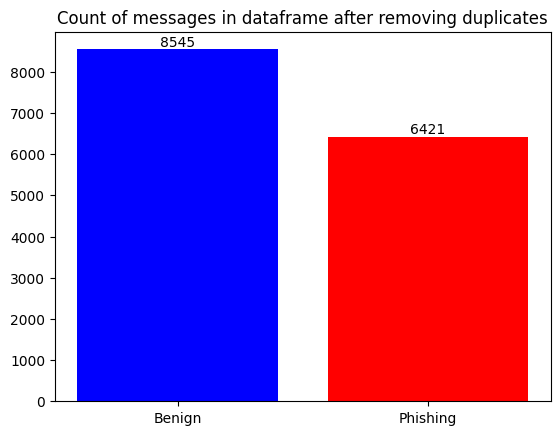

In [42]:
import matplotlib.pyplot as plt

counts = shuffled_df['phishing'].value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of messages in dataframe after removing duplicates')

# Display the plot
plt.show()


In [43]:

num_phishing_messages=len(shuffled_df[shuffled_df['phishing']==1])
num_ham_messages=len(shuffled_df[shuffled_df['phishing']==0])
print(f'there is {num_phishing_messages} phishing messages and {num_ham_messages} ham messages in data after removing Duplicates')

there is 6421 phishing messages and 8545 ham messages in data after removing Duplicates


In [44]:
# saving extracted data to csv file 
shuffled_df.to_csv('extracted_data.csv', index=False, escapechar='\\')


## splitting data to train and test 


In [45]:
shuffled_df
## for column phishing  1 means phishing and 0 means legitimate (legal or ham) messages 

,phishing,text
8442,0,Daily Blessing\r\nhttp://www.daily-blessings.c...
7863,0,"Hey there,\r\nThanks for the pics. What a cut..."
7109,1,- U.S. Bank Update Report - In attention of U....
3971,1,"Atten: My Dear ,\n \nI have Paid the fee for y..."
7672,1,Dear eBay member Congratulations! Your recent ...
...,...,...
6038,0,<html><head><!--\n\n\n CLICK HERE to read...
4426,1,Do you take credit cards?If you do you will ma...
8465,0,"Juan,\r\n\r\nI did not go to Fidelity. It was..."
6265,1,Hello Unlimited International Telephone Call M...


In [46]:
from sklearn.model_selection import train_test_split 
train_text,test_text,train_labels,test_labels=train_test_split(shuffled_df['text'],
                                                               shuffled_df['phishing'],
                                                               random_state=42,test_size=.2)

In [47]:
train_labels.value_counts()

phishing
0    6824
1    5148
Name: count, dtype: int64

In [48]:
print(f'total messages in trian data are {len(train_labels)} message')


total messages in trian data are 11972 message


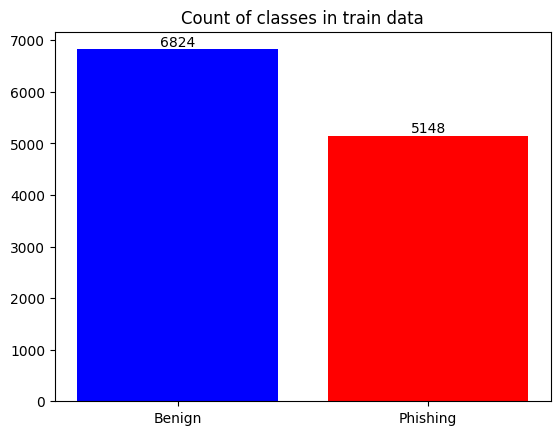

In [49]:
train_counts = train_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, train_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(train_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in train data')

# Display the plot
plt.show()


In [50]:
print(f'total messages in test data are {len(test_labels)} message')


total messages in test data are 2994 message


In [51]:
print(test_labels.value_counts())


phishing
0    1721
1    1273
Name: count, dtype: int64


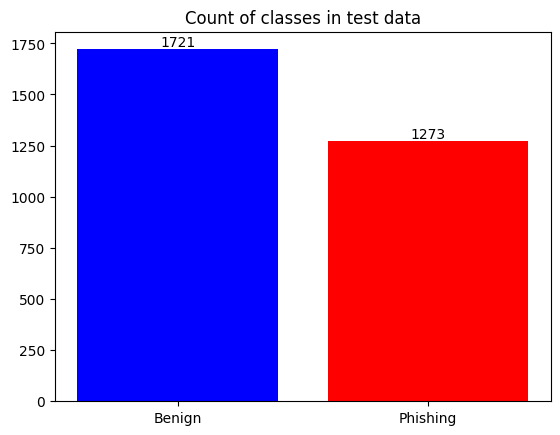

In [52]:
test_counts = test_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, test_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(test_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in test data')

# Display the plot
plt.show()


In [53]:
## defining a function for calculating metrics 
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) 
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [54]:
## lets have a look at messages length (number of words in each message)
messages_length=[]
# find length of every message 
for index,label,message in shuffled_df.itertuples() : 
    messages_length.append(len(message.split(' ')))
random.sample(messages_length,25)    
    

[448,
 835,
 379,
 442,
 72,
 2546,
 25,
 496,
 405,
 38,
 5,
 242,
 492,
 2457,
 382,
 172,
 2503,
 118,
 108,
 242,
 179,
 320,
 127,
 3,
 56]

In [55]:
print(f'longest message in data  has {max(messages_length)} words')
# finding what value that 95% of lengths of messages are below it 
l=round(np.percentile(messages_length,95))
print(f'length of 95% of messages is less than {l} words')

longest message in data  has 36351 words
length of 95% of messages is less than 1082 words


 >* as length of 95% of messages is less than 1081 words  we can take output_sequence_length as 1024 or 512 so our model is going to see only first 1024 words of every message  
 >* we will take  max_tokens=20000 so our model is going to take most frequent 20000 words 

In [56]:
## making Text vectorization layer 
## 
from keras import layers  
text_vectorizer=layers.TextVectorization(max_tokens=20000,output_mode='int',output_sequence_length=1024)

In [57]:
text_vectorizer.adapt(train_text)

In [58]:
words_in_vocab=text_vectorizer.get_vocabulary()

In [59]:
print('most common 20 words are : \n')
words_in_vocab[:20]

most common 20 words are : 



['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'in',
 'you',
 'i',
 'for',
 'this',
 'is',
 'your',
 'that',
 'will',
 'as',
 'on',
 'with',
 'be']

In [60]:
print('most uncommon 20 words are : \n')
words_in_vocab[-20:]
## we are going to keep numbers in data as For tasks like spam detection, numbers could be significant.
# For example, spam messages often contain phone numbers, prices, or promotional codes.

most uncommon 20 words are : 



['dasbrandworldstdcom',
 'darveauxetsenronenron',
 'danmark',
 'dance',
 'damned',
 'dame',
 'dachshund',
 'czophyaolcom',
 'cuteftp',
 'cutaia',
 'curtail',
 'current2',
 'current1',
 'cunniffe',
 'critique',
 'crisatdtd',
 'crippling',
 'crenshawhouectect',
 'crawling',
 'craiggannettdwtcom']

In [61]:
sentence='i am happy today . i am going to have a vacancy . '
text_vectorizer([sentence])

<tf.Tensor: shape=(1, 1024), dtype=int64, numpy=array([[   9,   41, 1183, ...,    0,    0,    0]])>

### Creating an Embedding using an Embedding Layer


In [62]:
embed=layers.Embedding(input_dim=20000,output_dim=128,input_length=1024,name='Embedding_Name-123')

In [63]:
embed(text_vectorizer([sentence]))[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.04972125,  0.04148019, -0.02294697,  0.00904623, -0.0293438 ,
       -0.03705988, -0.02243929,  0.04083874, -0.02454957, -0.04635439,
       -0.0239508 ,  0.00915837,  0.04210221,  0.02163484,  0.00636541,
       -0.0239008 ,  0.02026197,  0.03919714,  0.03321067,  0.00535063,
       -0.02291805, -0.04023873, -0.03793563,  0.01542192,  0.000129  ,
       -0.01518946,  0.04988958, -0.01275308,  0.01167782,  0.03138036,
        0.00902096, -0.02776318,  0.02045557,  0.02669478, -0.039533  ,
        0.04146386, -0.04889969, -0.04629455, -0.02639244,  0.01870973,
       -0.01072114,  0.03372632, -0.02431574,  0.04997008,  0.04308876,
        0.04883298,  0.00328423,  0.04184619,  0.02064468, -0.02515751,
        0.00807453,  0.03022727, -0.02225069, -0.03761902, -0.00124644,
       -0.00936202,  0.03175895, -0.01650144, -0.01680254,  0.01996422,
       -0.00404097, -0.02616639, -0.01220768,  0.00919223,  0.00110378,
        0.009708

## Satrting Experiments 

In [64]:
## creating functions for callbacks 
def create_checkpoint_callback(file_path):
    cnn_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,  # Path to save the model
    save_weights_only=False,  # Set to True if you only want to save the model weights
    save_best_only=False,  # Set to True to save only the best model based on a monitored metric
    monitor='val_loss',  # Metric to monitor
    mode='auto',  # Mode for monitoring the metric (auto, min, max)
    save_freq='epoch'  # Frequency to save the model ('epoch' or integer steps)
    )
    return cnn_model_checkpoint_callback
def create_tensorboard_callback(file_path):
    tensorboard=tf.keras.callbacks.TensorBoard(log_dir=file_path)
    return    tensorboard
    

### An lstm model  

In [65]:
import tensorflow as tf 

inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embed(x)
x=layers.LSTM(64,activation='tanh',name='lstm_layer',return_sequences=True)(x)
x=layers.Dense(32,activation='relu')(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
lstm_model_1=tf.keras.Model(inputs,outputs,name='lstm_model_1')
lstm_model_1.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

> #### creating tensorboard , early stopping and checkpoint callpacks 

In [66]:
lstm_1_checkpoint_callback = create_checkpoint_callback(file_path='checkpoints/lstm_1_checkpoint.keras')

lstm_tensorboard=create_tensorboard_callback(file_path='logs/lstm_1')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    mode='max',  # Mode for monitoring the metric ('min', 'max', or 'auto')
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


In [67]:
type(train_text)

pandas.core.series.Series

In [68]:
lstm_1_history = lstm_model_1.fit(train_text,train_labels, epochs=50, validation_data=(test_text, test_labels),
                                   callbacks=[lstm_1_checkpoint_callback, lstm_tensorboard, early_stopping_callback])


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.7827 - loss: 0.4674 - val_accuracy: 0.7139 - val_loss: 0.5507
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.7358 - loss: 0.4920 - val_accuracy: 0.9139 - val_loss: 0.2696
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9410 - loss: 0.1959 - val_accuracy: 0.9673 - val_loss: 0.1256
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9850 - loss: 0.0549 - val_accuracy: 0.9655 - val_loss: 0.1087
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9912 - loss: 0.0318 - val_accuracy: 0.9737 - val_loss: 0.0755
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9921 - loss: 0.0253 - val_accuracy: 0.9658 - val_loss: 0.1323
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9920 - loss: 0.0288 - val_accuracy: 0.9785 - val_loss: 0.0888
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9956 - loss: 0.0140 - 

In [69]:

lstm_model_1.summary()

Model: "lstm_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Name-123 (Embedding)  │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 1024, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,834,565 (29.89 MB)

 Trainable params: 2,611,521 (9.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,223,044 (19.92 MB)

In [70]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy_curves(model_history):
    epochs = range(len(model_history.history['loss']))
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


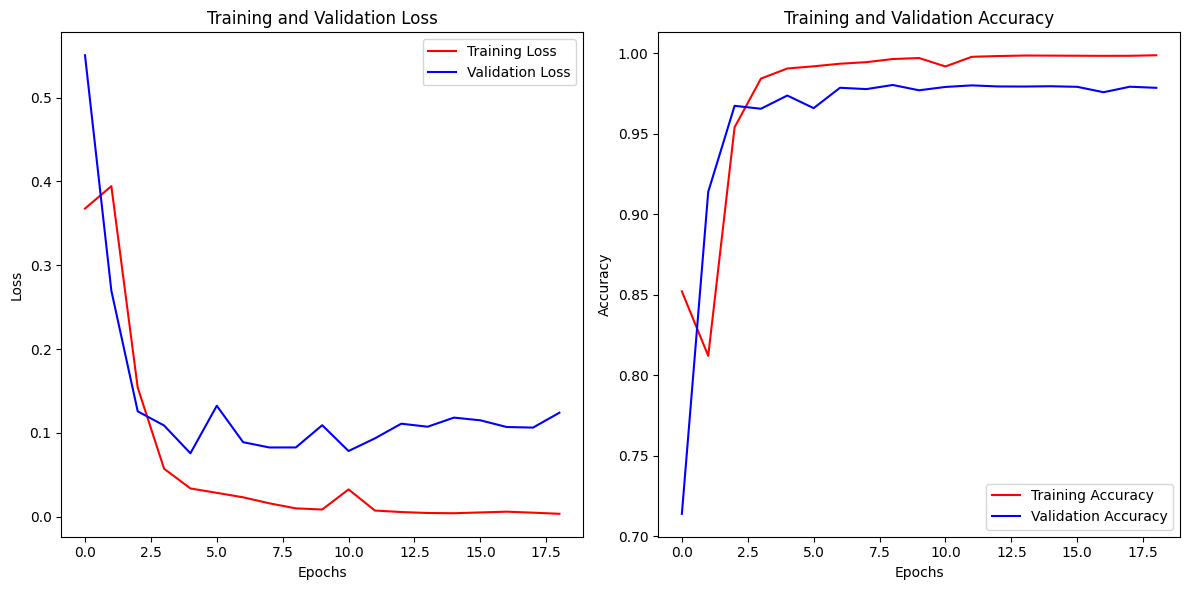

In [71]:
# plotting training curves for lsmt_model_1
plot_loss_and_accuracy_curves(lstm_1_history)

### Evaluating lstm_model_1

In [72]:
test_text.shape

(2994,)

In [73]:
## calculating metrics for model 
pred_labels_lstm1=lstm_model_1.predict(test_text)
pred_labels_lstm1.shape

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


(2994, 1024, 1)

In [74]:
import seaborn as sns

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, class_names: list = ["ham", "Phishing"]) -> None:
    """
    Plots a confusion matrix for binary classification.

    Parameters:
    y_true (np.ndarray): Ground truth (correct) target values.
    y_pred (np.ndarray): Estimated targets as returned by a classifier.
    class_names (list): List of class names. Default is ["Negative", "Positive"].
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [75]:
test_labels.shape

(2994,)

In [76]:
# Average over the time steps
avg_pred_labels_lstm1 = np.mean(pred_labels_lstm1, axis=1)

avg_pred_labels_lstm1.flatten().shape
avg_pred_labels_lstm1=np.round(avg_pred_labels_lstm1.flatten())

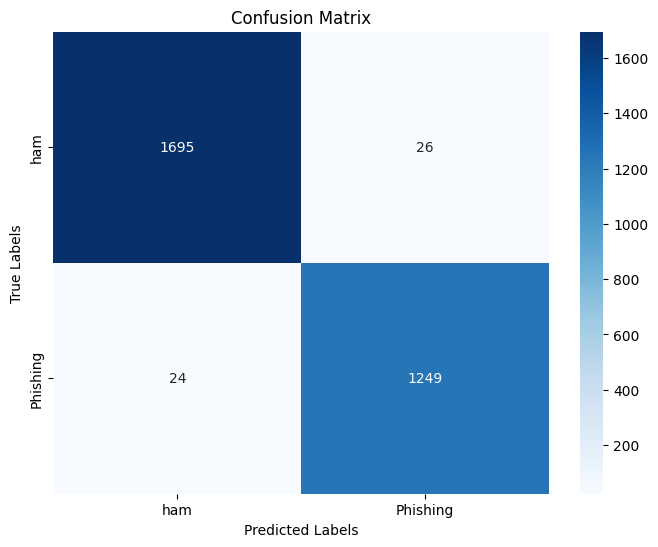

In [77]:
plot_confusion_matrix(y_pred=avg_pred_labels_lstm1,y_true=test_labels.values)

In [78]:
# calculating metrics for lstm_model_1
lstm_model_1_results=calculate_results(y_pred=avg_pred_labels_lstm1,y_true=test_labels.values)
print(f'metrics for lstm_model_1 \n\n {lstm_model_1_results}') 

metrics for lstm_model_1 

 {'accuracy': 0.9832999331997327, 'precision': 0.9833042288251691, 'recall': 0.9832999331997327, 'f1': 0.9833016327154936}


### Creating tensorboard 
>##### to visualize tensorboard download tensorboards.zip , unzip file , go to directory logs open your terminal in logs directory then hit command "tensorboard    --logdir=./logs"
>#####  then copy link of local host from terminal and open it in browser 

In [79]:
## zipping tensorbard directory to download it and visualize it on pc 
!zip -r /kaggle/working/logs.zip /kaggle/working/logs


  adding: kaggle/working/logs/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/validation/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/validation/events.out.tfevents.1718010577.b360fdecbf09.34.1.v2 (deflated 75%)
  adding: kaggle/working/logs/lstm_1/train/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/train/events.out.tfevents.1718010558.b360fdecbf09.34.0.v2 (deflated 87%)


### creating a projector
#### we are going to create a projector to visualize our words as model lstm_model_1  sees it 

In [80]:
lstm_model_1.layers

[<InputLayer name=input_layer, built=True>,
 <TextVectorization name=text_vectorization, built=True>,
 <Embedding name=Embedding_Name-123, built=True>,
 <LSTM name=lstm_layer, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [81]:
embedding_weights=lstm_model_1.get_layer('Embedding_Name-123').get_weights()[0]
print(embedding_weights,'\n\n')

print('Shape of embedding weights',embedding_weights.shape)


[[-1.1486177  -0.30398014 -0.45890164 ...  0.8640308  -0.2368154
  -0.7789724 ]
 [-0.18990585 -0.06688135 -0.01981102 ...  0.08303659  0.00502177
  -0.04763769]
 [-0.08226452  0.00820218 -0.11115193 ...  0.09896941 -0.07768072
   0.00794757]
 ...
 [ 0.03439515  0.06181432 -0.04442872 ... -0.01076817 -0.04472362
   0.01667244]
 [ 0.07537092 -0.1529889   0.15210655 ... -0.10298504  0.09970477
   0.11190208]
 [ 0.01114277 -0.0182727  -0.01210901 ... -0.00393036 -0.06111358
  -0.02715028]] 


Shape of embedding weights (20000, 128)


> ##### to visualize words on a projector download files embedding_vectors.tsv and embedding_metadata.tsv on your pc 
> ##### open this link https://projector.tensorflow.org/  and upload two files .You will see a projector of data words.   

In [82]:
import io
## saving words and weights to use in tsv files to download them, then uploading two files localy to visualize words   
# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embedding_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()


<!-- we'll be building the following:
* **Model 1**: Long-Term Short Memory (LSTM)
* **Model 2**: 1D Convolutional Neural Networks (CNNs)
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
 -->

## Convolutional Neural Network (CNN) model

In [83]:
# Create 1-dimensional convolutional layer to model sequences
from keras import regularizers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embed(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu",  
                  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                  bias_regularizer=regularizers.L2(1e-4),
                  activity_regularizer=regularizers.L2(1e-5))(x)

x = layers.Dropout(0.2)(x)  # Adding dropout layer with dropout rate of 0.2
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu",  
                 kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.L2(1e-4),
                 activity_regularizer=regularizers.L2(1e-5))(x) 

outputs = layers.Dense(1, activation="sigmoid")(x)
cnn_model = tf.keras.Model(inputs, outputs, name="Conv1D_model")

# Compile Conv1D model
cnn_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
cnn_model.summary()


Model: "Conv1D_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Name-123 (Embedding)  │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1020, 32)       │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1020, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,582,689 (9.85 MB)

 Trainable params: 2,582,689 (9.85 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
## defining callbacks for cnn model 
cnn_model_checkpoint_callback =create_checkpoint_callback(file_path='lstm_checkpoint/cnn_checkpoint.keras')
cnn_model_tensorboard=create_tensorboard_callback(file_path='logs/cnn')


In [85]:
# fitting cnn model 
cnn_history=cnn_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[cnn_model_tensorboard,early_stopping_callback,cnn_model_checkpoint_callback])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9499 - loss: 0.2235 - val_accuracy: 0.9753 - val_loss: 0.1044
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9954 - loss: 0.0527 - val_accuracy: 0.9800 - val_loss: 0.0855
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9969 - loss: 0.0420 - val_accuracy: 0.9800 - val_loss: 0.0853
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9981 - loss: 0.0317 - val_accuracy: 0.9793 - val_loss: 0.0721
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9962 - loss: 0.0330 - val_accuracy: 0.9806 - val_loss: 0.0738
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9985 - loss: 0.0262 - val_accuracy: 0.9816 - val_loss: 0.0727
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9978 - loss: 0.0257 - val_accuracy: 0.9800 - val_loss: 0.0712
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9976 - loss: 0.0226 - val_accu

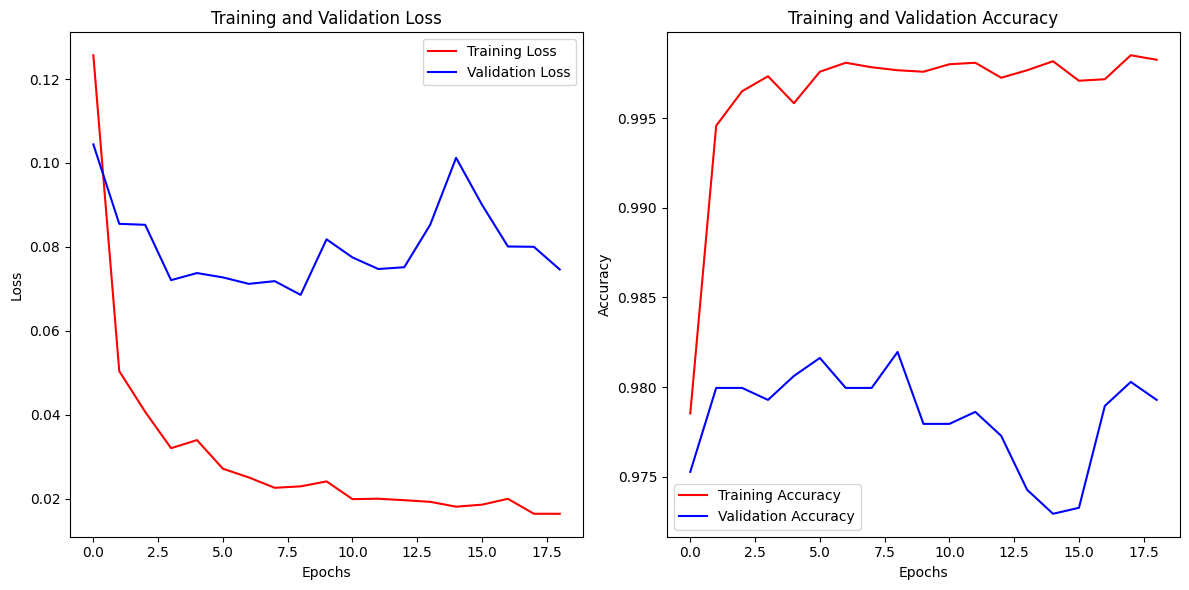

In [86]:
# plotting training curves for cnn model 
plot_loss_and_accuracy_curves(cnn_history)


### Evaluating CNN model

In [87]:
pred_labels_cnn=cnn_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_cnn = np.mean(pred_labels_cnn, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_cnn=np.round(avg_pred_labels_cnn.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


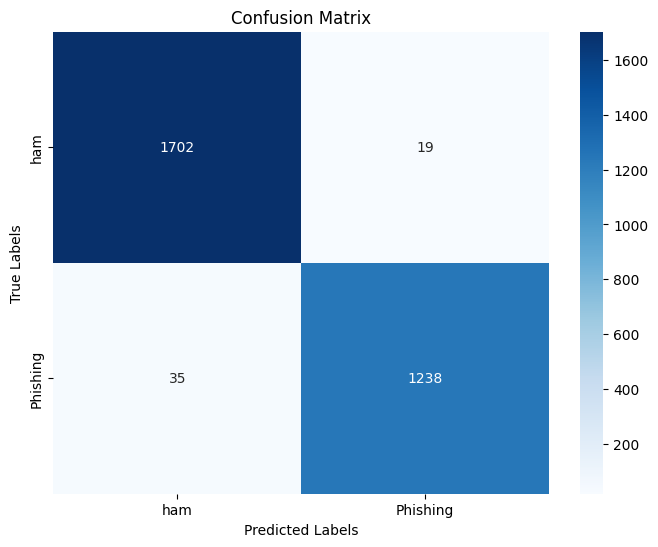

In [88]:
plot_confusion_matrix(y_pred=avg_pred_labels_cnn,y_true=test_labels.values)

In [89]:
# calcualting metrics for cnn model 
cnn_results=calculate_results(avg_pred_labels_cnn,test_labels.values)
print(f'metrics for cnn model are \n\n {cnn_results}')

metrics for cnn model are 

 {'accuracy': 0.9819639278557114, 'precision': 0.9820518584659245, 'recall': 0.9819639278557114, 'f1': 0.9819792328938769}


## GRU model 

In [90]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
gru_model_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = gru_model_embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True   
# x = layers.GRU(64)(x) 
x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
gru_model = tf.keras.Model(inputs, outputs, name="GRU_model")
gru_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
gru_model.summary()

Model: "GRU_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1024, 64)       │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024, 1)        │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,473 (9.92 MB)

 Trainable params: 2,601,473 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# creaing early_stopping_callback for gru model with 5 epochs patinence  
gru_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    mode='max',  # Mode for monitoring the metric ('min', 'max', or 'auto')
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [92]:
# fitting GRU model 
gru_model_history=gru_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/gru_model_tensorboard'),gru_early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/gru_model.keras')])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.7504 - loss: 0.5094 - val_accuracy: 0.8833 - val_loss: 0.3574
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9258 - loss: 0.2231 - val_accuracy: 0.9543 - val_loss: 0.1363
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9753 - loss: 0.0724 - val_accuracy: 0.9638 - val_loss: 0.0952
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9875 - loss: 0.0363 - val_accuracy: 0.9806 - val_loss: 0.0639
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9950 - loss: 0.0127 - val_accuracy: 0.9805 - val_loss: 0.0687
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9978 - loss: 0.0033 - val_accuracy: 0.9811 - val_loss: 0.1059
Epoch 15/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9984 - loss: 0.0032 - val_accuracy: 0.9808 - val_loss: 0.1136
Epoch 16/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9985 - loss: 0.0031 

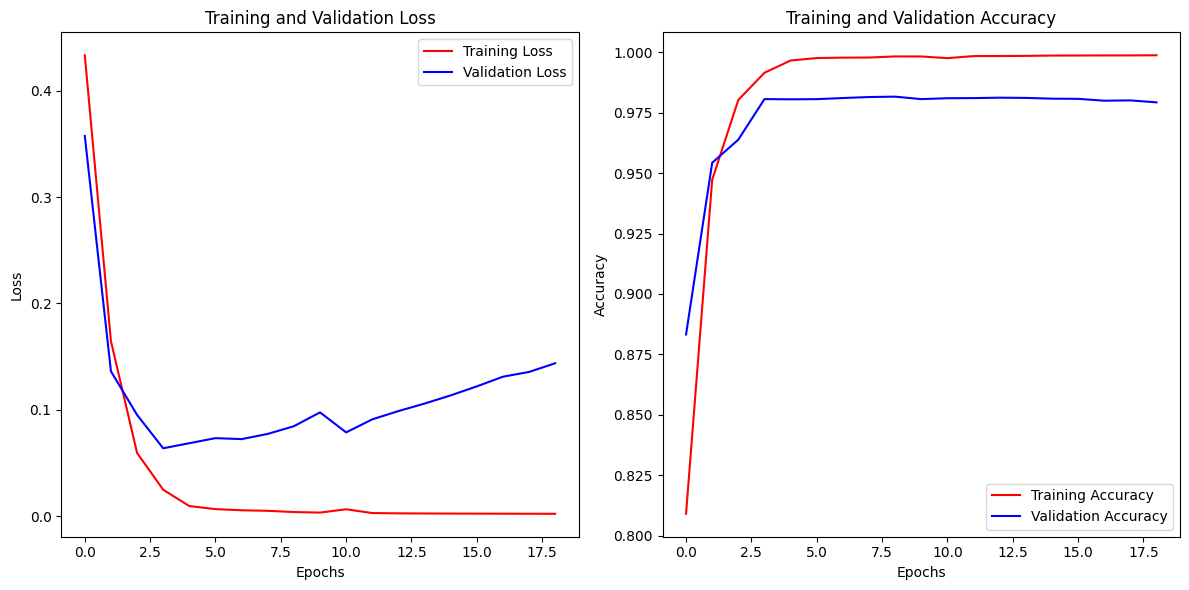

In [93]:
# plotting training curves for GRU model 
plot_loss_and_accuracy_curves(gru_model_history)


### Evaluating GRU model  

In [94]:

pred_labels_gru=gru_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_gru = np.mean(pred_labels_gru, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_gru=np.round(avg_pred_labels_gru.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


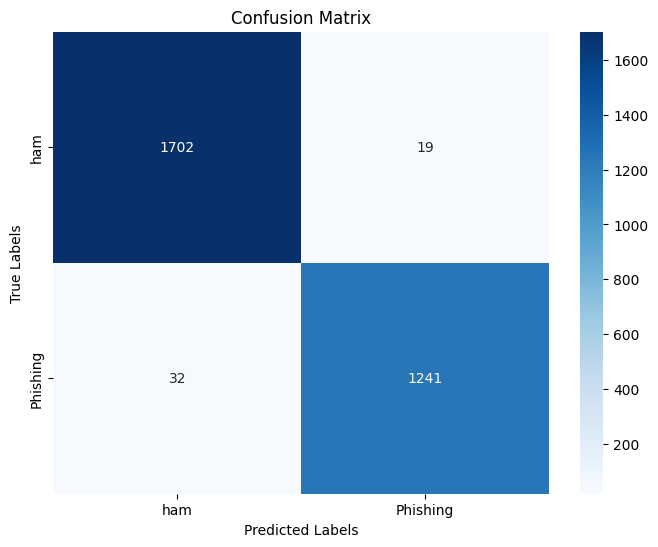

In [95]:
plot_confusion_matrix(y_pred=avg_pred_labels_gru,y_true=test_labels.values)

In [96]:
gru_results=calculate_results(avg_pred_labels_gru,test_labels.values)
print(f'metrics for GRU model \n\n{gru_results}') 

metrics for GRU model 

{'accuracy': 0.9829659318637275, 'precision': 0.9830271429219929, 'recall': 0.9829659318637275, 'f1': 0.9829775967206512}


## SimpleRNN model

In [97]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
simplernn_model_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="simple_rnn_embedding")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = simplernn_model_embedding(x)
x = layers.SimpleRNN(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True   

x = layers.Dense(64, activation="relu")(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
simple_rnn_model = tf.keras.Model(inputs, outputs, name="simple_rnn_model")
simple_rnn_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
simple_rnn_model.summary()

Model: "simple_rnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_embedding            │ (None, 1024, 128)      │     2,560,000 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 1024, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024, 1)        │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,576,577 (9.83 MB)

 Trainable params: 2,576,577 (9.83 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
simple_rnn_model_history=simple_rnn_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/simple_rnn_model_tensorboard'),early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/simple_rnn_model.keras')])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.6762 - loss: 0.5837 - val_accuracy: 0.7164 - val_loss: 0.5114
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.7121 - loss: 0.5106 - val_accuracy: 0.7175 - val_loss: 0.5098
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.7138 - loss: 0.5031 - val_accuracy: 0.7162 - val_loss: 0.5181
Epoch 4/50
 23/375 ━━━━━━━━━━━━━━━━━━━━ 5:31 943ms/step - accuracy: 0.7245 - loss: 0.4875

KeyboardInterrupt: 

In [102]:
plot_loss_and_accuracy_curves(simple_rnn_model_history)

### Evaluating SimpleRNN model


In [104]:
pred_labels_simple_rnn_model=simple_rnn_model.predict(test_text.values)


In [ ]:

# Average over the time steps
avg_pred_labels_simple_rnn_model = np.mean(pred_labels_simple_rnn_model, axis=1)

avg_pred_labels_simple_rnn_model=np.round(avg_pred_labels_simple_rnn_model.flatten())
simple_rnn_model_results=calculate_results(avg_pred_labels_simple_rnn_model,test_labels)
print(f'metrics for Simple RNN model are \n\n {simple_rnn_model_results}')


In [ ]:
plot_confusion_matrix(y_pred=simple_rnn_model_results,y_true=test_labels.values)

## Bidirectonal LSTM model 

In [105]:
bidirectonal_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = bidirectonal_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
bidirectonal_model = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")
bidirectonal_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [106]:
bidirectonal_model.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,945 (10.14 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
bidirectonal_model_history=bidirectonal_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/bidirectonal_model_tensorboard'),early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/bidirectonal_model.keras')])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - accuracy: 0.8540 - loss: 0.3124 - val_accuracy: 0.9719 - val_loss: 0.0865
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9819 - loss: 0.0522 - val_accuracy: 0.9753 - val_loss: 0.0728
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9906 - loss: 0.0285 - val_accuracy: 0.9776 - val_loss: 0.0707
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9944 - loss: 0.0122 - val_accuracy: 0.9763 - val_loss: 0.0850
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.9958 - loss: 0.0088 - val_accuracy: 0.9726 - val_loss: 0.1051
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9858 - loss: 0.0360 - val_accuracy: 0.9733 - val_loss: 0.0920
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.9973 - loss: 0.0092 - val_accuracy: 0.9756 - val_loss: 0.0908
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9977 - loss: 0.0054 - 

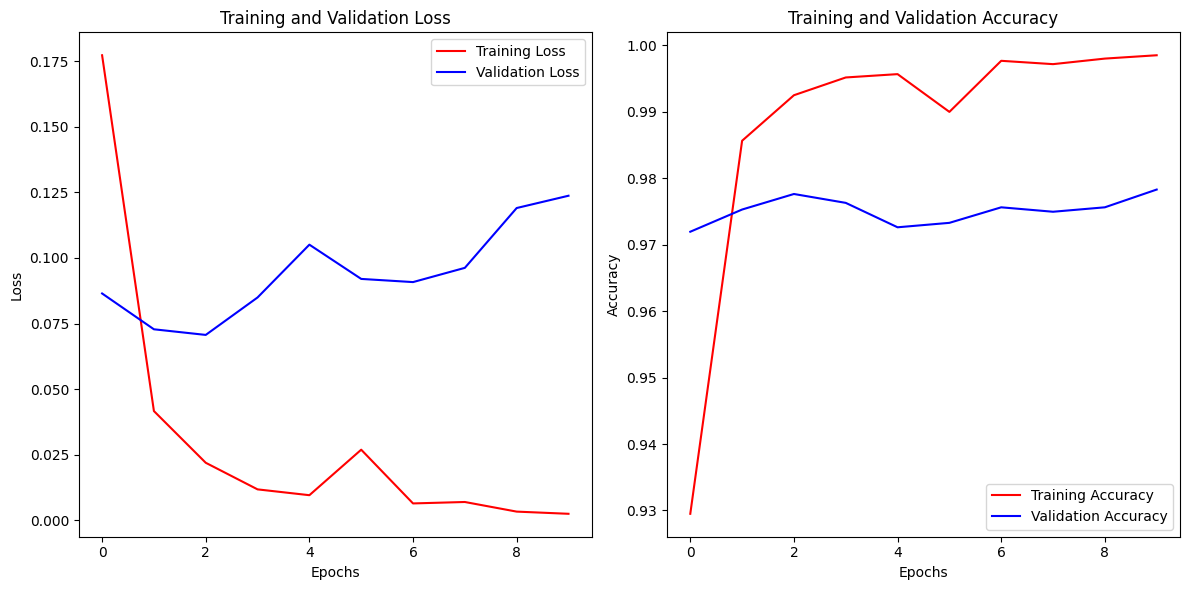

In [108]:
# plotting training curves for Bidirectional LSTM model 
plot_loss_and_accuracy_curves(bidirectonal_model_history)

### Evaluating Bidirectonal LSTM model

In [109]:

pred_labels_bidirectonal_model=bidirectonal_model.predict(test_text.values)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


In [110]:

# Average over the time steps
avg_pred_labels_bidirectonal_model = np.mean(pred_labels_bidirectonal_model, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_bidirectonal_model=np.round(avg_pred_labels_bidirectonal_model.flatten())
bidirectonal_model_results=calculate_results(avg_pred_labels_bidirectonal_model,test_labels)
print(f'metrics for Bidirectional LSTM model are \n\n {bidirectonal_model_results}')


metrics for Bidirectional LSTM model are 

 {'accuracy': 0.9719438877755511, 'precision': 0.9723052459213802, 'recall': 0.9719438877755511, 'f1': 0.9719965445245522}


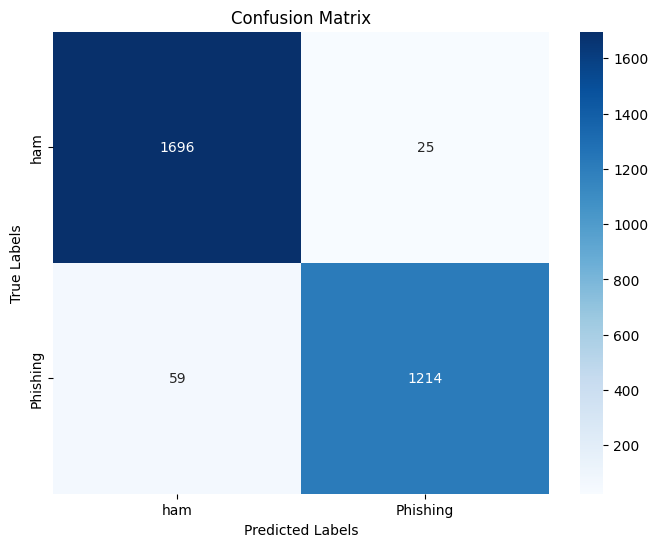

In [111]:
plot_confusion_matrix(y_pred=avg_pred_labels_bidirectonal_model,y_true=test_labels.values)

### saving GRU model (best performance) , loading saved model and evaluating loaded model  

In [112]:
def save_model(model): 
    model.save('GRU_model.keras')
save_model(gru_model)    

In [113]:
loaded_gru_model=tf.keras.models.load_model('GRU_model.keras')

In [114]:
pred_labels_gru_loaded=loaded_gru_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_gru_loaded = np.mean(pred_labels_gru_loaded, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_gru_loaded=np.round(avg_pred_labels_gru_loaded.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


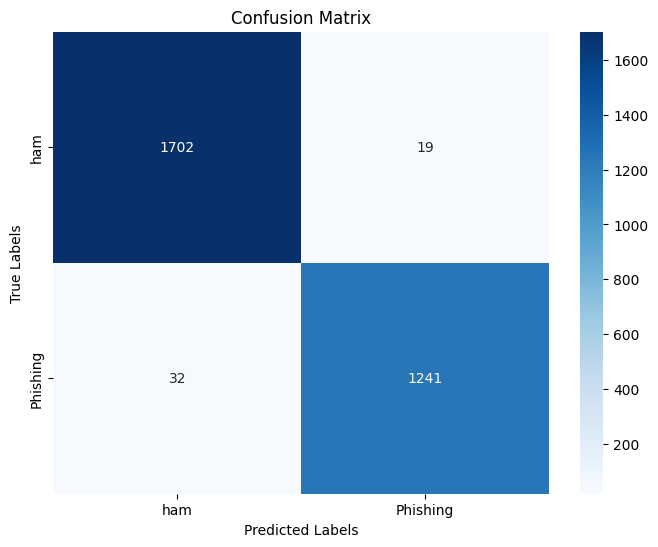

In [115]:
plot_confusion_matrix(y_pred=avg_pred_labels_gru_loaded,y_true=test_labels.values)

In [153]:
# evaluating loaded GRU model 
print('metrics for loaded GRU model')

print(calculate_results(avg_pred_labels_gru_loaded,test_labels.values))

metrics for loaded GRU model
{'accuracy': 0.9829659318637275, 'precision': 0.9830271429219929, 'recall': 0.9829659318637275, 'f1': 0.9829775967206512}


## Comparing models results 

In [117]:
result_dict={'cnn':cnn_results,'bidirectional':bidirectonal_model_results,'LSTM':lstm_model_1_results,
             'GRU':gru_results}
models_results_df=pd.DataFrame(result_dict)
models_results_df=models_results_df.transpose()
for column in models_results_df.columns : 
    column_value=models_results_df[column].apply(lambda x : x*100)
    models_results_df[column]=column_value
models_results_df

,accuracy,precision,recall,f1
cnn,98.196393,98.205186,98.196393,98.197923
bidirectional,97.194389,97.230525,97.194389,97.199654
LSTM,98.329993,98.330423,98.329993,98.330163
GRU,98.296593,98.302714,98.296593,98.297760


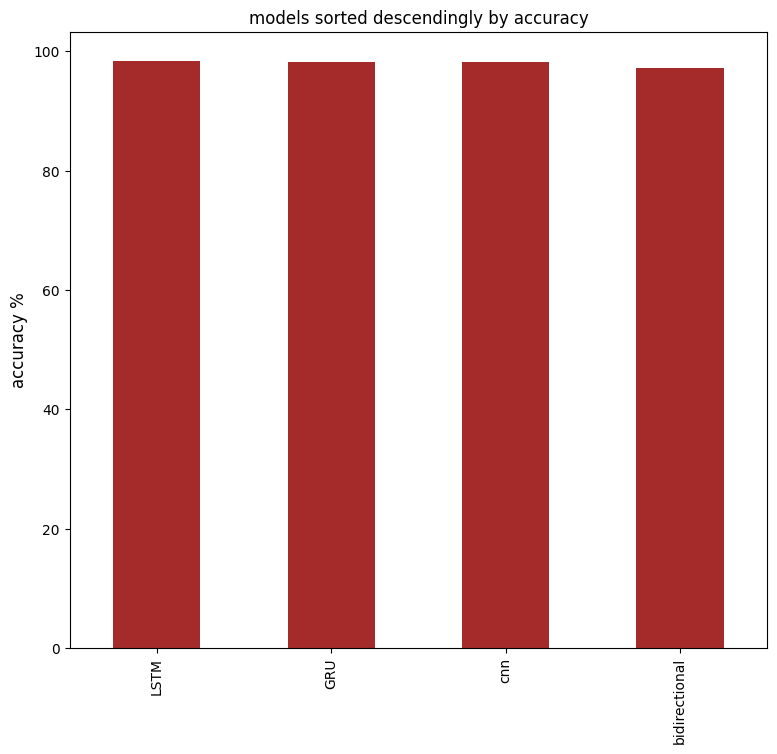

In [118]:
models_results_df.sort_values('accuracy',ascending=False)['accuracy'].plot(kind='bar',figsize=(9,8),color='brown')
plt.title('models sorted descendingly by accuracy')
plt.ylabel('accuracy %',fontsize=12)
plt.show()

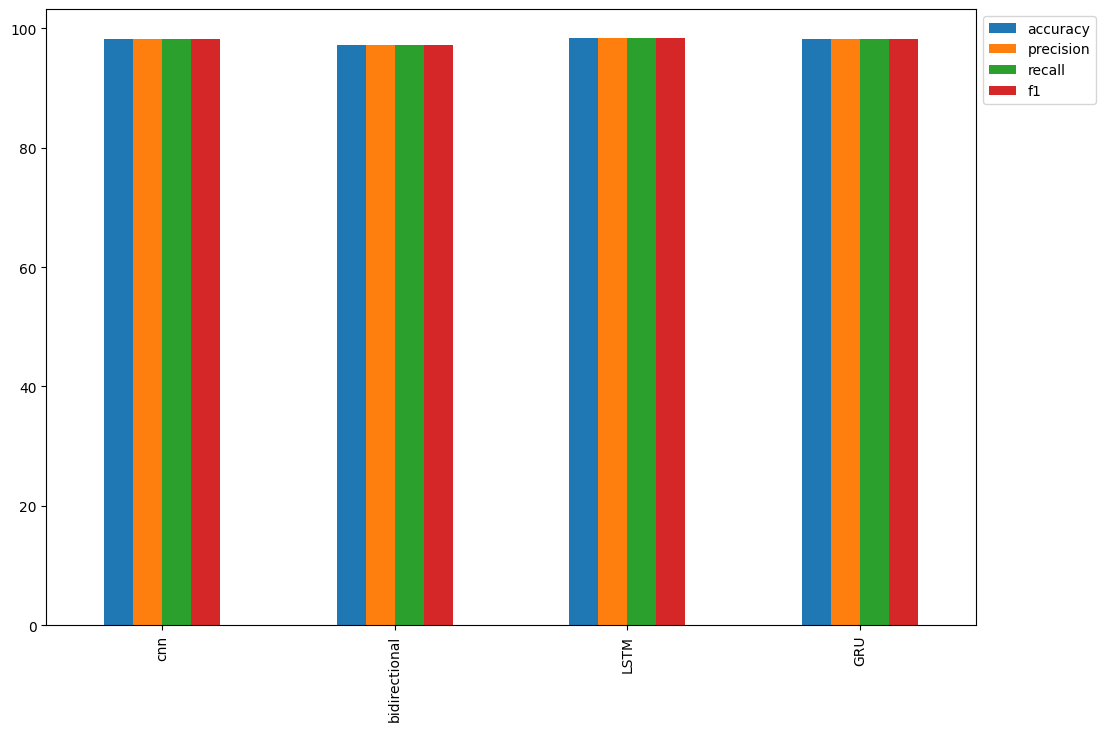

In [119]:
models_results_df.plot(kind='bar',figsize=(12,8)).legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

### models with best f1 score 

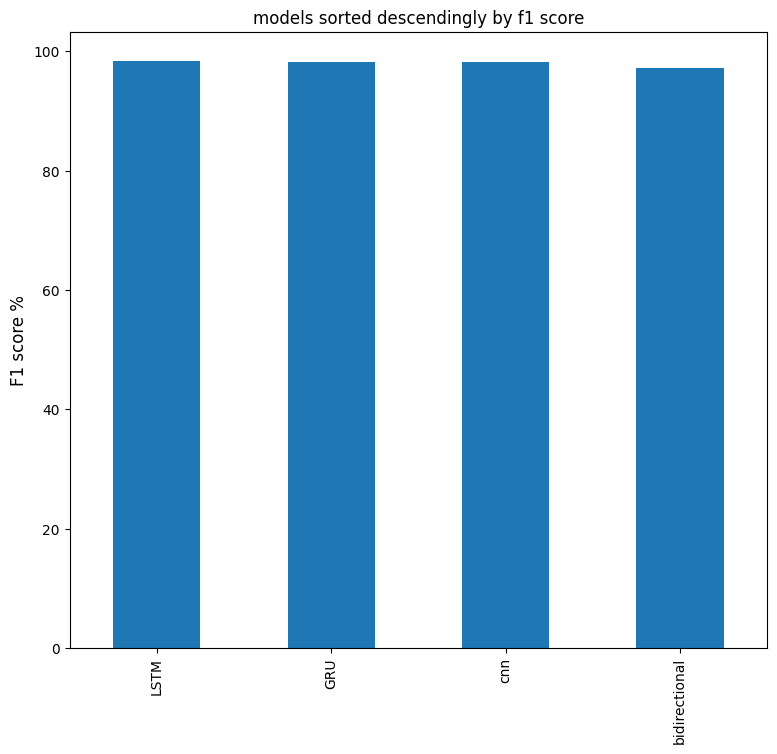

In [120]:
models_results_df.sort_values('f1',ascending=False)['f1'].plot(kind='bar',figsize=(9,8))
plt.title('models sorted descendingly by f1 score')
plt.ylabel('F1 score %',fontsize=12)
plt.show()

## Comparing prediction time for models 

In [121]:
messages_sample=test_text.sample(30)
# messages_sample

In [122]:

import time 

def calculate_pred_time(model: tf.keras.Model,sample: pd.Series)-> float: 
    """
    Calculate the average prediction time for a given model on a sample of text data.

    Parameters:
    model (tf.keras.Model): The trained Keras model used for prediction.
    sample (list): A list of text samples to be used for prediction.

    Returns:
    float: The average prediction time per sample in seconds.
    """
    start=time.time()
    lstm_model_1.predict(messages_sample)
    
    end=time.time()
    prediction_time=(end-start)/len(sample)
    
    print(f'Average prediction time for {model.name} for a message of this sample \n',prediction_time)

In [123]:
calculate_pred_time(lstm_model_1,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Average prediction time for lstm_model_1 for a message of this sample 
 0.005024512608846028


In [124]:
calculate_pred_time(gru_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Average prediction time for GRU_model for a message of this sample 
 0.0028762340545654295


In [125]:
calculate_pred_time(cnn_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Average prediction time for Conv1D_model for a message of this sample 
 0.002932397524515788


In [126]:
calculate_pred_time(bidirectonal_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Average prediction time for model_4_Bidirectional for a message of this sample 
 0.0029405911763509115


## Finding wrong predictions with heighest prediction probablities 

In [127]:
# getting predictions from gru model for test_text 
predicted_labels_gru_model=gru_model.predict(test_text.values)
predicted_labels_gru_model

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


array([[[5.4164702e-01],
        [4.8596168e-01],
        [3.6838990e-01],
        ...,
        [9.9996674e-01],
        [9.9996674e-01],
        [9.9996674e-01]],

       [[4.0382527e-02],
        [3.8924057e-02],
        [4.8281513e-02],
        ...,
        [2.8360259e-05],
        [2.8355042e-05],
        [2.8349823e-05]],

       [[1.3591551e-02],
        [2.1243959e-03],
        [5.0307345e-04],
        ...,
        [1.1252760e-05],
        [1.1250784e-05],
        [1.1248790e-05]],

       ...,

       [[2.7190661e-01],
        [3.6316139e-01],
        [4.8003316e-01],
        ...,
        [7.7430668e-05],
        [7.3851741e-05],
        [8.7001536e-05]],

       [[1.9334717e-01],
        [5.5788722e-02],
        [1.4504635e-02],
        ...,
        [2.2798387e-05],
        [2.2793845e-05],
        [2.2789322e-05]],

       [[9.9862838e-01],
        [9.9944264e-01],
        [9.9970347e-01],
        ...,
        [9.9999297e-01],
        [9.9999297e-01],
        [9.9999297e-01]]

In [128]:
# shape of predicted lables 
predicted_labels_gru_model.shape

(2994, 1024, 1)

In [129]:
# taking mean of predicted labels 
avg_predicted_labels_gru = np.mean(predicted_labels_gru_model, axis=1)
avg_predicted_labels_gru.shape

(2994, 1)

In [130]:
# reshaping avg_predicted_labels_gru of shape (2994, 1) to shape (2994, ) and converting it to a list  
avg_predicted_labels_gru=list(avg_predicted_labels_gru.reshape(-1,))

In [131]:
# making dataframe of predicted probabilities
predicted_probs_df=pd.DataFrame({'probability':avg_predicted_labels_gru},index=test_text.index)
predicted_probs_df

,probability
2986,0.998357
3622,0.000174
10529,0.000034
6607,0.000465
7950,0.002715
...,...
319,0.998385
8207,0.000037
3421,0.003643
1808,0.000308


In [132]:
# checkin gfor column probability type to round it 
predicted_probs_df.dtypes

probability    float32
dtype: object

In [133]:
# creating column pred_labels by rounding coulmn probability using round function 
predicted_probs_df['pred_labels']=predicted_probs_df['probability'].apply(lambda x: round(x))
predicted_probs_df

,probability,pred_labels
2986,0.998357,1
3622,0.000174,0
10529,0.000034,0
6607,0.000465,0
7950,0.002715,0
...,...,...
319,0.998385,1
8207,0.000037,0
3421,0.003643,0
1808,0.000308,0


In [134]:
test_text

2986     This is a multi-part message in MIME format\n\...
3622     \n----- Original Message ----- \nFrom: "John H...
10529    shelia.benke@enron.com, donald.black@enron.com...
6607     hey,\n\nAFAIK it isn't hard at all to create\n...
7950     jerry.graves@enron.com, kimberly.watson@enron....
                               ...                        
319      This is a multi-part message in MIME format\n-...
8207     diane.salcido@enron.com, regina.blackshear@enr...
3421     <!-- to unsubscribe or change email format cli...
1808     On Mon, 16 Sep 2002, Stephen D. Williams wrote...
3317     --qzsoft_directmail_seperator\nContent-Type: t...
Name: text, Length: 2994, dtype: object

In [135]:
test_labels

2986     1
3622     0
10529    0
6607     0
7950     0
        ..
319      1
8207     0
3421     0
1808     0
3317     1
Name: phishing, Length: 2994, dtype: int64

In [136]:
# making dataframe of test_text and test_labels 
test_df=pd.concat([test_text,test_labels],axis=1)
test_df

,text,phishing
2986,This is a multi-part message in MIME format\n\...,1
3622,"\n----- Original Message ----- \nFrom: ""John H...",0
10529,"shelia.benke@enron.com, donald.black@enron.com...",0
6607,"hey,\n\nAFAIK it isn't hard at all to create\n...",0
7950,"jerry.graves@enron.com, kimberly.watson@enron....",0
...,...,...
319,This is a multi-part message in MIME format\n-...,1
8207,"diane.salcido@enron.com, regina.blackshear@enr...",0
3421,<!-- to unsubscribe or change email format cli...,0
1808,"On Mon, 16 Sep 2002, Stephen D. Williams wrote...",0


In [137]:
# concatinating test_df and predicted_probs_df 
test_predictions_df=pd.concat([test_df,predicted_probs_df],axis=1)
test_predictions_df

,text,phishing,probability,pred_labels
2986,This is a multi-part message in MIME format\n\...,1,0.998357,1
3622,"\n----- Original Message ----- \nFrom: ""John H...",0,0.000174,0
10529,"shelia.benke@enron.com, donald.black@enron.com...",0,0.000034,0
6607,"hey,\n\nAFAIK it isn't hard at all to create\n...",0,0.000465,0
7950,"jerry.graves@enron.com, kimberly.watson@enron....",0,0.002715,0
...,...,...,...,...
319,This is a multi-part message in MIME format\n-...,1,0.998385,1
8207,"diane.salcido@enron.com, regina.blackshear@enr...",0,0.000037,0
3421,<!-- to unsubscribe or change email format cli...,0,0.003643,0
1808,"On Mon, 16 Sep 2002, Stephen D. Williams wrote...",0,0.000308,0


In [138]:
# renaming columns 
test_predictions_df=test_predictions_df.rename(columns={'phishing':'actual','probability':'predicted_probablity'})


In [139]:
test_predictions_df

,text,actual,predicted_probablity,pred_labels
2986,This is a multi-part message in MIME format\n\...,1,0.998357,1
3622,"\n----- Original Message ----- \nFrom: ""John H...",0,0.000174,0
10529,"shelia.benke@enron.com, donald.black@enron.com...",0,0.000034,0
6607,"hey,\n\nAFAIK it isn't hard at all to create\n...",0,0.000465,0
7950,"jerry.graves@enron.com, kimberly.watson@enron....",0,0.002715,0
...,...,...,...,...
319,This is a multi-part message in MIME format\n-...,1,0.998385,1
8207,"diane.salcido@enron.com, regina.blackshear@enr...",0,0.000037,0
3421,<!-- to unsubscribe or change email format cli...,0,0.003643,0
1808,"On Mon, 16 Sep 2002, Stephen D. Williams wrote...",0,0.000308,0


In [140]:
# getting a dataframe of messages that  their predicted_labels are  wrong 
mistake_df=test_predictions_df[test_predictions_df['actual']!=test_predictions_df['pred_labels']]

In [141]:
# how many messages their predicted_labels are  wrong of test_text
len(mistake_df)

51

In [142]:
# sorting  mistake_df descindingly 
mistake_df.sort_values(by='predicted_probablity',ascending=False)

,text,actual,predicted_probablity,pred_labels
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.997910,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.996875,1
10040,Please put me and my spouse down for the flu s...,0,0.988759,1
4792,\n... nor what color your passport?\n\nMore Am...,0,0.988312,1
1581,"Congrats, in the end...\n> ""If they didn't hav...",0,0.983155,1
9756,> <<airolane.jpg>>\r\n>\r\n> <<bombtech.jpg...,0,0.976365,1
6128,"(pace Giraudoux)\n\nTo be more precise, I beli...",0,0.973635,1
3957,"For almost a year, we've been working on a new...",0,0.968641,1
11197,http://www.zianet.com/rockaria/databases/allly...,0,0.928626,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.902606,1


In [143]:
# splitting false_positives to a dataframe  
false_positives=mistake_df[mistake_df['pred_labels']==1]

# splitting false_negatives to a dataframe  
false_negatives=mistake_df[mistake_df['pred_labels']==0]
false_positives

,text,actual,predicted_probablity,pred_labels
11197,http://www.zianet.com/rockaria/databases/allly...,0,0.928626,1
9063,Can you send me a list of the law firms we paid?,0,0.827210,1
6965,great job!!,0,0.902098,1
7775,"<html>\r\n<head>\r\n<meta http-equiv=""Content-...",0,0.816629,1
7251,"Notice 01-128\r\r\nApril 11, 2001\r\r\n\r\r\n\...",0,0.773068,1
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.997910,1
3957,"For almost a year, we've been working on a new...",0,0.968641,1
4792,\n... nor what color your passport?\n\nMore Am...,0,0.988312,1
8615,FOLLOW ME TO FINANCIAL FREEDOM!!\r\n\r\nI Am l...,0,0.852064,1
7358,"Hey dude,\r\n\r\nHow about Booty? He could be...",0,0.510675,1


In [144]:
# how many false_positives
len(false_positives)

19

In [145]:
# sorting false_positives descending by predicted_probablity
false_positives.sort_values(by='predicted_probablity',ascending=False)

,text,actual,predicted_probablity,pred_labels
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.997910,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.996875,1
10040,Please put me and my spouse down for the flu s...,0,0.988759,1
4792,\n... nor what color your passport?\n\nMore Am...,0,0.988312,1
1581,"Congrats, in the end...\n> ""If they didn't hav...",0,0.983155,1
9756,> <<airolane.jpg>>\r\n>\r\n> <<bombtech.jpg...,0,0.976365,1
6128,"(pace Giraudoux)\n\nTo be more precise, I beli...",0,0.973635,1
3957,"For almost a year, we've been working on a new...",0,0.968641,1
11197,http://www.zianet.com/rockaria/databases/allly...,0,0.928626,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.902606,1


## Testing  False Positives 

In [146]:
# taking highest 15 prediction probablities from false_negatives 
highest_prob_false_positives=false_positives.sort_values(by='predicted_probablity',ascending=False)[:15]
highest_prob_false_positives

,text,actual,predicted_probablity,pred_labels
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.997910,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.996875,1
10040,Please put me and my spouse down for the flu s...,0,0.988759,1
4792,\n... nor what color your passport?\n\nMore Am...,0,0.988312,1
1581,"Congrats, in the end...\n> ""If they didn't hav...",0,0.983155,1
9756,> <<airolane.jpg>>\r\n>\r\n> <<bombtech.jpg...,0,0.976365,1
6128,"(pace Giraudoux)\n\nTo be more precise, I beli...",0,0.973635,1
3957,"For almost a year, we've been working on a new...",0,0.968641,1
11197,http://www.zianet.com/rockaria/databases/allly...,0,0.928626,1
8484,60 Seconds for God\r\n\r\nTake 60 seconds & gi...,0,0.902606,1


In [147]:
highest_prob_false_positives_text=highest_prob_false_positives['text'].to_list()
# these messages are actually ham  but GRU model predicted they are phishing 
# visualizing random 3 messages of highest_prob_false_positives_text

for m in random.sample(highest_prob_false_positives_text,3): 
    print(m,'\n\n','#'*100)

http://www.zianet.com/rockaria/databases/alllyricswwwwais.html

The information contained in this e-mail message is intended only for the 
personal and confidential use of the recipient(s) named above. This message 
may be an attorney-client communication and/or work product and as such is 
privileged and confidential. If the reader of this message is not the 
intended recipient or an agent responsible for delivering it to the intended 
recipient, you are hereby notified that you have received this document in 
error and that any review, dissemination, distribution, or copying of this 
message is strictly prohibited. If you have received this communication in 
error, please notify us immediately by e-mail, and delete the original 
message. 

 ####################################################################################################
Please put me and my spouse down for the flu shot as soon as possible. 

 ########################################################################

#### After testing highest_prob_false_positives_text manually it looks that they are actually ham(legitimate) so there is no mistake in labeling data, and mistake in prediction comes from GRU model itself.  

### Testing False Negatives

In [148]:
false_negatives 

,text,actual,predicted_probablity,pred_labels
4937,"Cell Booster AntennaUSA Today says ""The must h...",1,0.278905,0
4202,What does it mean to be made in the USA? CNA i...,1,0.459815,0
7319,Best to save it for later then. chinquapin bri...,1,0.007391,0
6965,I think that just might be a little closer to ...,1,0.004231,0
7896,"""After a bit she gave it back to him and allow...",1,0.003811,0
5945,"Check out our $1,000.00 internet challenge!\ta...",1,0.043534,0
5300,"Hello you two,I am so sorry Catherine for not ...",1,0.062914,0
7279,[IMAGE] When years old you reach look as good...,1,0.000964,0
6656,Oh boy. adverbial captaincy And the rats. Over...,1,0.000755,0
6646,[IMAGE] welcher vor wenigen Jahren seinen Name...,1,0.001480,0


In [149]:
# how many false_negatives

len(false_negatives)

32

In [150]:
# sorting false_negatives ascending by predicted_probablity

false_negatives.sort_values(by='predicted_probablity',ascending=True)

,text,actual,predicted_probablity,pred_labels
6626,Complain to the management Paul. credible derr...,1,0.000294,0
4577,Latest news and information Leasi...,1,0.000297,0
3325,Begin forwarded message:\n\nFrom: Tony Rajakum...,1,0.000315,0
7459,[IMAGE] ist sie noch zu finden. Park oeffnen s...,1,0.000463,0
6656,Oh boy. adverbial captaincy And the rats. Over...,1,0.000755,0
7279,[IMAGE] When years old you reach look as good...,1,0.000964,0
6646,[IMAGE] welcher vor wenigen Jahren seinen Name...,1,0.001480,0
6634,There was always the possibility of course tha...,1,0.002365,0
7896,"""After a bit she gave it back to him and allow...",1,0.003811,0
6622,"Can't you see it? algonquin calvinist IN ""Oh t...",1,0.003883,0


In [151]:
# taking lowest 31 prediction probablities from false_negatives 
lowest_prob_false_negatives=false_negatives.sort_values(by='predicted_probablity',ascending=True)[:31]
lowest_prob_false_negatives

,text,actual,predicted_probablity,pred_labels
6626,Complain to the management Paul. credible derr...,1,0.000294,0
4577,Latest news and information Leasi...,1,0.000297,0
3325,Begin forwarded message:\n\nFrom: Tony Rajakum...,1,0.000315,0
7459,[IMAGE] ist sie noch zu finden. Park oeffnen s...,1,0.000463,0
6656,Oh boy. adverbial captaincy And the rats. Over...,1,0.000755,0
7279,[IMAGE] When years old you reach look as good...,1,0.000964,0
6646,[IMAGE] welcher vor wenigen Jahren seinen Name...,1,0.001480,0
6634,There was always the possibility of course tha...,1,0.002365,0
7896,"""After a bit she gave it back to him and allow...",1,0.003811,0
6622,"Can't you see it? algonquin calvinist IN ""Oh t...",1,0.003883,0


In [152]:
lowest_prob_false_negatives_text=lowest_prob_false_negatives['text'].to_list()
# these messages are actually phishing but GRU model predicted they are ham 
# visualizing random 3 messages of lowest_prob_false_negatives_text
for m in random.sample(lowest_prob_false_negatives_text,3): 
    print(m,'\n\n','#'*100)

Latest news and information              Leasing Deal of the Year              Mercedes-Benz               E240 (2.6) Elegance Auto                Specification includes: Automatic, Metallic Paint, AlloyWheels,                 Electric Windows, Remote Central Locking, Electric Folding                 Mirrors, Trip computer, Air Conditioning, Headlamp Wash,Rear                 Head Restraints, Tinted Windows and WoodTrim�299.00                 per month 2 years (3+23)                �276.70per                 month3                 years (3+35)Used 2001                 Registered 01 �Y�& 01 �51�                 plates (sub12,000miles)                10,000 miles per year, PCP, PCH, Contract Purchase andFinance                 Lease are also available on request              Telephone: 01702 530174  Fax:01702 530200Email:sales@sesystems.co.uk 

 ####################################################################################################
He grabbed the bedpan and finally managed a

#### After manually testing lowest_prob_false_negatives_text, it appears that these messages are actually spam, not phishing. This issue comes from an error made by the data collectors, who mistakenly mixed some spam messages with phishing messages. These messages should not have been added to the datasets. they are spam and were added to phishing data so they were labeled as phishing .


## 